# Product Insights and Visuals

## Notebook Objective

In this notebook, I explore product-level behavior and purchasing patterns within the Instacart dataset. The goal is to identify which products drive the most volume, which items are most frequently reordered, and how product performance varies across categories, departments, and time.

This analysis is structured to surface insights that could support a range of operational decisions, including product placement, promotion targeting, inventory prioritization, and recommendation strategy. I use SQL for data aggregation and filtering, and Python visualizations to communicate key patterns in a clear, interpretable format.

Key questions addressed include:
- What are the most popular products by volume?
- Which products or categories have the highest reorder rates?
- How does purchasing behavior differ by aisle or department?
- Are there any patterns in product selection by day of week or time of day?
- What can we infer about user basket composition and diversity?

I combine SQL queries with summary tables, bar charts, and optional interactive visuals to highlight both broad trends and specific product opportunities.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

conn = sqlite3.connect(":memory:")

order_products = pd.read_csv("../data/processed/joined_order_products.csv")
order_products.to_sql("order_products", conn, index=False, if_exists="replace");


## 1. Top-Selling Products

Identify which individual products are ordered most frequently across all users.

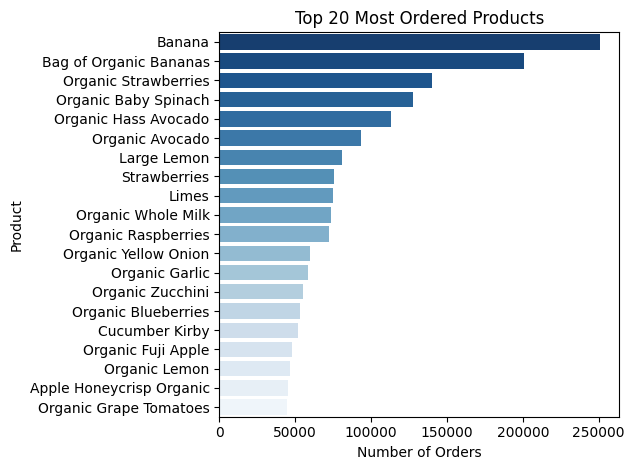

In [2]:
query_top_products = """
SELECT product_name, COUNT(*) AS total_orders
FROM order_products
GROUP BY product_name
ORDER BY total_orders DESC
LIMIT 20;
"""

top_products = pd.read_sql_query(query_top_products, conn)

# Bar plot
sns.barplot(data=top_products, x='total_orders', y='product_name', hue='product_name', palette='Blues_r', legend=False)
plt.title("Top 20 Most Ordered Products")
plt.xlabel("Number of Orders")
plt.ylabel("Product")
plt.tight_layout()
plt.show()


### Interpretation: Top 20 Most Ordered Products

This chart shows the 20 products with the highest total number of orders across all users. These items represent the most frequently selected products on the platform. The results are likely driven by commonly used grocery staples, suggesting consistent demand. The high concentration of volume among a small group of products may also indicate which items are most essential to users’ weekly baskets. Understanding these trends can help prioritize availability and pricing decisions for high-impact items.

## 2. Most Frequently Reordered Products

Highlight which products users tend to purchase again — a proxy for habit, loyalty, or essential items.

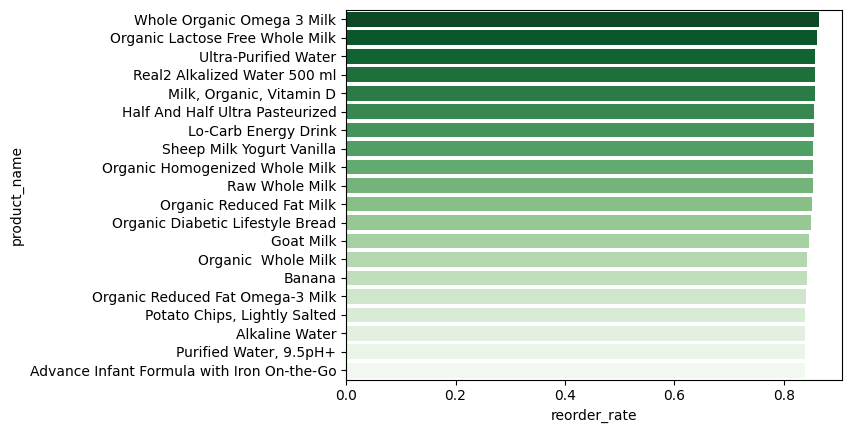

In [3]:
query_reorder_ratio = """
SELECT product_name,
       COUNT(*) AS total_orders,
       SUM(reordered) * 1.0 / COUNT(*) AS reorder_rate
FROM order_products
GROUP BY product_name
HAVING total_orders >= 100
ORDER BY reorder_rate DESC
LIMIT 20;
"""

top_reordered = pd.read_sql_query(query_reorder_ratio, conn)

# Bar plot
sns.barplot(
    data=top_reordered,
    x='reorder_rate',
    y='product_name',
    hue='product_name',
    palette='Greens_r',
    legend=False
);


### Interpretation: Most Frequently Reordered Products

This chart highlights the products with the highest reorder rates among those with at least 100 total orders. High reorder rates suggest strong customer loyalty or habitual usage for those products. Many of the top items may be essentials such as produce, dairy, or beverages that customers need regularly. These insights can help identify which products are most likely to drive recurring purchases and should be considered in reorder reminder strategies or featured placements.

## 3. Department and Aisle-Level Trends

Analyze product activity and reorder behavior across broader categories.

In [4]:
# Load products and departments
products = pd.read_csv("../data/raw/products.csv")
departments = pd.read_csv("../data/raw/departments.csv")

# Load into SQLite
products.to_sql("products", conn, index=False, if_exists="replace")
departments.to_sql("departments", conn, index=False, if_exists="replace")

21

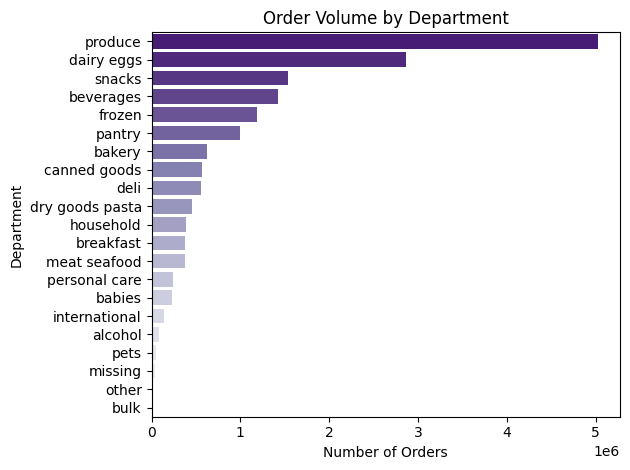

In [5]:
query_dept_orders = """
SELECT d.department, COUNT(*) AS total_orders
FROM order_products op
JOIN products p ON op.product_id = p.product_id
JOIN departments d ON p.department_id = d.department_id
GROUP BY d.department
ORDER BY total_orders DESC;
"""

dept_orders = pd.read_sql_query(query_dept_orders, conn)

ax = sns.barplot(
    data=dept_orders,
    y='department',
    x='total_orders',
    hue='department',          
    palette='Purples_r',
    legend=False
)

plt.title("Order Volume by Department")
plt.xlabel("Number of Orders")
plt.ylabel("Department")
plt.tight_layout()
plt.show()

### Interpretation: Order Volume by Department

This bar chart shows the total number of product orders grouped by department. A small number of departments—such as produce, dairy, and snacks—account for a large share of all product activity. These departments are likely central to typical user baskets and represent areas where user engagement is strongest. Other departments with lower volume may represent niche categories or less frequently needed items. This distribution can inform how to allocate space, promotions, or recommendations across categories.

## 4. Product Patterns by Time of Day or Day of Week

Identify if certain products or categories are more likely to be ordered at specific times or on specific days.

In [6]:
# Load cleaned orders data
orders = pd.read_csv("../data/processed/orders_cleaned.csv")
orders.to_sql("orders", conn, index=False, if_exists="replace");

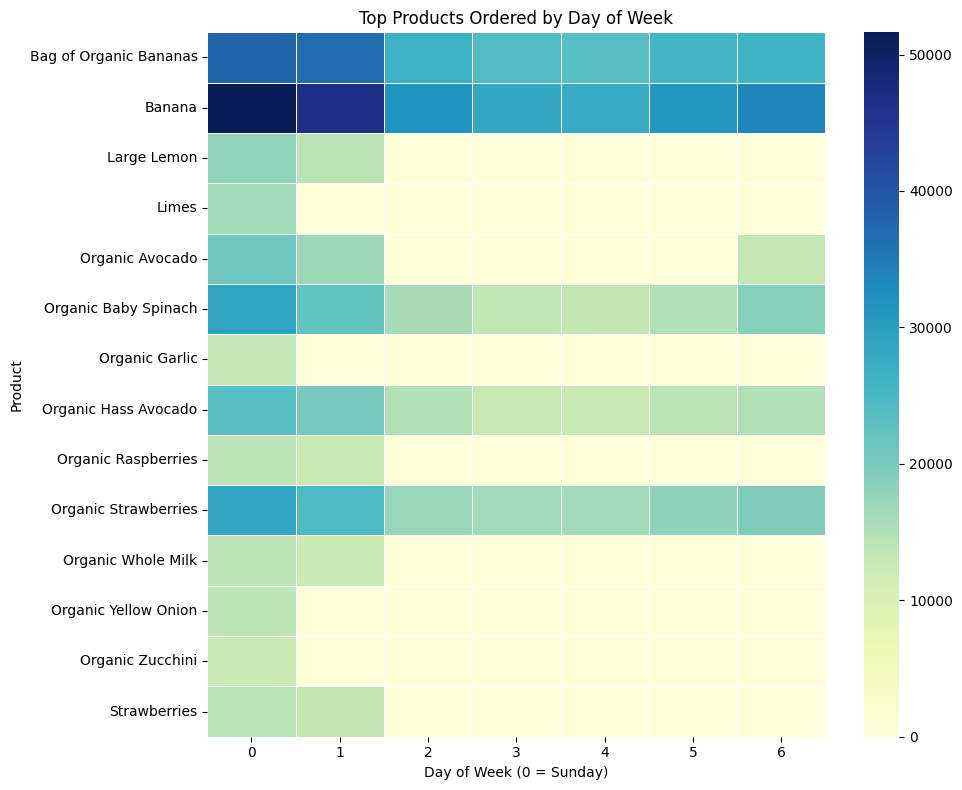

In [7]:
query_dow_products = """
SELECT op.product_name, o.order_dow, COUNT(*) AS order_count
FROM order_products op
JOIN orders o ON op.order_id = o.order_id
GROUP BY op.product_name, o.order_dow
HAVING order_count > 1000
ORDER BY order_count DESC
LIMIT 50;
"""

dow_products = pd.read_sql_query(query_dow_products, conn)

# Optional: Use pivot to prep for heatmap
heatmap_data = dow_products.pivot_table(index='product_name', columns='order_dow', values='order_count', fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5)
plt.title("Top Products Ordered by Day of Week")
plt.xlabel("Day of Week (0 = Sunday)")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

### Interpretation: Product Ordering Patterns by Day of Week

The heatmap displays the number of orders for the top 50 products across each day of the week. Some products show steady ordering patterns, while others peak on specific days, possibly due to planned weekly routines. For example, certain items may see more activity on weekends, suggesting a preparation for the upcoming week. Understanding when specific products are most in demand can help with operational planning, such as inventory restocking or delivery resource allocation.

## 5. Basket Size and Product Diversity

Examine how many products users typically order, and how varied their baskets are.

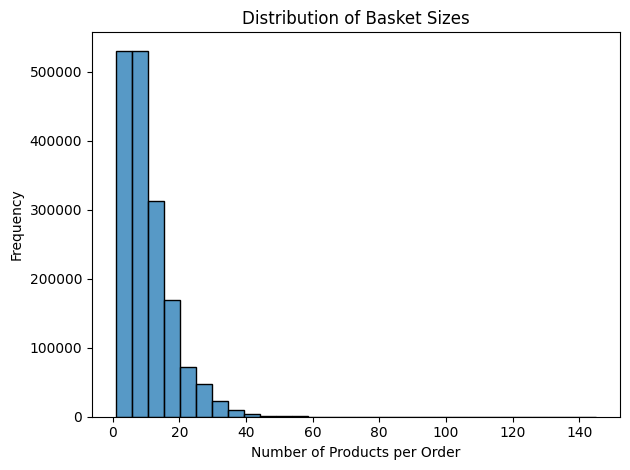

In [8]:
query_basket_sizes = """
SELECT order_id, COUNT(product_id) AS basket_size
FROM order_products
GROUP BY order_id;
"""

basket_sizes = pd.read_sql_query(query_basket_sizes, conn)

# Histogram of basket sizes
sns.histplot(basket_sizes['basket_size'], bins=30, kde=False)
plt.title("Distribution of Basket Sizes")
plt.xlabel("Number of Products per Order")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Interpretation: Distribution of Basket Sizes

This histogram shows how many products users typically include in a single order. Most baskets contain between 5 and 15 items, with a steep drop-off after that point. Very large baskets (40+ items) are rare, indicating that bulk purchases or large household restocks are less common. The skewed distribution suggests that users are generally shopping for short- to medium-term needs rather than stocking up. This pattern may reflect regular weekly usage, which could inform assumptions around delivery frequency and inventory planning.

## 6. Key Takeaways

- A small number of products account for a large share of total orders, with grocery staples like produce and dairy consistently appearing at the top. These items likely form the foundation of most user baskets.

- Products with high reorder rates tend to be basic household essentials. Their consistent presence across orders suggests they are important for retaining long-term customers.

- Departments such as produce, dairy, and snacks drive the highest order volumes. This concentration highlights which parts of the catalog are most critical from an operational or promotional perspective.

- Most users place relatively small to medium-sized orders, with basket sizes typically ranging between 5 and 15 items. Very large baskets are uncommon, suggesting regular shopping habits rather than bulk buying.

- Product demand remains steady across the week, though certain items show higher activity on specific days. These shifts could reflect weekly routines or timing around restocking behavior.

Overall, this analysis provides a clear view of how users interact with the product catalog — what they rely on regularly, how often they repurchase, and when they are most active. These findings can support more focused decisions around inventory, marketing timing, and product prioritization.
